In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [3]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train_en'), flavor=None)
X_test, y_test = read_data(get_dataset('valid_en'), flavor=None)

2018-12-03 14:59:06,401 [INFO] Reading /opt/storage/english_train.csv..
2018-12-03 14:59:06,616 [INFO] Reading /opt/storage/english_valid.csv..


In [5]:
from fgclassifier.utils import get_stats, load_model

model = load_model('tfidf_en_sv_dense', 'LDA')

In [6]:
scores = model.predict(X_train)
scores.shape

2018-12-03 14:59:31,940 [INFO]   tfidf_en_sv_dense: transform use cache.


(2000, 20)

In [7]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [8]:
from fgclassifier.features import FeaturePipeline, logger

for name in ['count_en', 'tfidf_en',
             'lsa_200_en', 'lsa_500_en', 'lsa_1k_en',
             'count_en_sv', 'tfidf_en_sv', 'tfidf_en_sv_dense',
             'lsa_200_en_sv', 'lsa_500_en_sv']:
    logger.info(f'Building features for {name}...')
    model = FeaturePipeline.from_spec(name, cache=fm)
    model.fit_transform(X_train)
    model.transform(X_test)

2018-12-03 14:59:42,575 [INFO] Building features for count_en...
2018-12-03 14:59:42,577 [INFO] Fit & Transform CountVectorizer...
2018-12-03 15:00:04,051 [INFO] Vocab Size: 1828
2018-12-03 15:00:05,159 [INFO] Building features for tfidf_en...
2018-12-03 15:00:05,161 [INFO]   count_en: fit_transform use cache.
2018-12-03 15:00:05,162 [INFO] Fit & Transform TF-IDF...
2018-12-03 15:00:05,217 [INFO]   count_en: transform use cache.
2018-12-03 15:00:05,228 [INFO] Building features for lsa_200_en...
2018-12-03 15:00:05,231 [INFO]   tfidf_en: fit_transform use cache.
2018-12-03 15:00:05,233 [INFO] Fit & Transform TruncatedSVD...
2018-12-03 15:00:06,756 [INFO]   tfidf_en: transform use cache.
2018-12-03 15:00:06,781 [INFO] Building features for lsa_500_en...
2018-12-03 15:00:06,783 [INFO]   tfidf_en: fit_transform use cache.
2018-12-03 15:00:06,784 [INFO] Fit & Transform TruncatedSVD...
2018-12-03 15:00:10,888 [INFO]   tfidf_en: transform use cache.
2018-12-03 15:00:10,942 [INFO] Building fea

Exam the quality of the top terms:

In [9]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count_en', 'count_en_sv']:
    model = fm[mn]['model'].named_steps[mn]
    x_train = fm[mn]['train']
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.2f, max_df: %.2f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:10]]))

Data Shape: (8000,) (2000,)

min_df: 0.01, max_df: 1.00, ngram_range: (1, 4)

vocab size: 1828

good 	 18975
taste 	 13095
eat 	 11877
time 	 7277
delicious 	 7088
store 	 6968
like 	 6532
people 	 6217
dishes 	 5931
really 	 5711

min_df: 0.02, max_df: 1.00, ngram_range: (1, 4)

vocab size: 953

good 	 18975
taste 	 13095
eat 	 11877
time 	 7277
delicious 	 7088
store 	 6968
like 	 6532
people 	 6217
dishes 	 5931
really 	 5711


In [10]:
fm['tfidf_en']['model'].named_steps

{'count_en': FeaturePipeline(steps=count_en),
 'tfidf_en': Tfidf(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}

## The Very Basic TF-IDF + LDA classifier

In [11]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.classifiers import LDA
from fgclassifier.train import fm_cross_check

In [12]:
# Linear Discriminant Analysis, specify the FeaturePipeline
# as steps
model = Baseline(('LDA', LDA), fm=fm['lsa_200_en']['model'])

# Always pass in the original features
# the pipeline will take care of the cashe
model.fit(X_train, y_train)
print(model.name)
print('Final score:', model.score(X_test, y_test))

2018-12-03 15:02:11,355 [INFO]   lsa_200_en: fit_transform use cache.
2018-12-03 15:02:19,318 [INFO]   lsa_200_en: transform use cache.
2018-12-03 15:02:19,348 [INFO] [Validate]: F1 Scores
2018-12-03 15:02:19,352 [INFO]   location_traffic_convenience            	0.4451
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-03 15:02:19,365 [INFO]   location_distance_from_business_district	0.3053
2018-12-03 15:02:19,368 [INFO]   location_easy_to_find                   	0.3502
2018-12-03 15:02:19,373 [INFO]   service_wait_time                       	0.3544
2018-12-03 15:02:19,376 [INFO]   service_waiters_attitude                	0.5659
2018-12-03 15:02:19,380 [INFO]   service_parking_convenience             	0.4954
2018-12-03 15:02:19,386 [INFO]   service_serving_speed                   

lsa_200_en_LDA
Final score: 0.40987258736630244


In [13]:
model.scores(X_test, y_test)

2018-12-03 15:02:19,506 [INFO]   lsa_200_en: transform use cache.
2018-12-03 15:02:19,588 [INFO] [Validate]: F1 Scores
2018-12-03 15:02:19,600 [INFO]   location_traffic_convenience            	0.4451
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-03 15:02:19,608 [INFO]   location_distance_from_business_district	0.3053
2018-12-03 15:02:19,615 [INFO]   location_easy_to_find                   	0.3502
2018-12-03 15:02:19,619 [INFO]   service_wait_time                       	0.3544
2018-12-03 15:02:19,623 [INFO]   service_waiters_attitude                	0.5659
2018-12-03 15:02:19,625 [INFO]   service_parking_convenience             	0.4954
2018-12-03 15:02:19,629 [INFO]   service_serving_speed                   	0.4249
2018-12-03 15:02:19,634 [INFO]   price_level                  

[0.4451257331181293,
 0.3052584660459037,
 0.35018175903486004,
 0.35442498945641226,
 0.5659257910724396,
 0.49536678340805607,
 0.4248992672001867,
 0.47718139014567734,
 0.39365309369693985,
 0.47287908869994444,
 0.4039847975783586,
 0.377089817740745,
 0.3985799698671706,
 0.4154502223238977,
 0.34729387713502047,
 0.4981512648513745,
 0.31400974949469296,
 0.3333265938345696,
 0.4459512880557882,
 0.37871780456588366]

## Search for the Best Feature + Classifier Combination

In [14]:
# Run for all classifiers and feature builders
all_avg_scores, all_scores = defaultdict(dict), defaultdict(dict)

In [15]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [16]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'avg': all_avg_scores,
        'all': all_scores
    }
}

# We'd only need to run the dummy models on one feature model,
# as they do not care about the features
fm_cross_check(
    ['tfidf_en'],
    ['DummyStratified', 'DummyMostFrequent'],
    model_cls=Dummy, **conf)

# Naive Bayes models cannot handle negative values, so we pass
# in only tfidf features
fm_cross_check(
    ['tfidf_en', 'tfidf_en_sv'],
    ['MultinomialNB', 'ComplementNB'], **conf)

# All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_200_en',
     'lsa_500_en',
     'lsa_1k_en',
     'tfidf_en_sv_dense',
     'lsa_200_en_sv',
     'lsa_500_en_sv',
    ],
    ['LDA', 'LinearSVC', 'Logistic', 'Ridge'], **conf)

2018-12-03 15:02:35,699 [INFO] 
2018-12-03 15:02:35,701 [INFO] ============ Feature Model: tfidf_en ============
2018-12-03 15:02:35,703 [INFO] 
2018-12-03 15:02:35,705 [INFO] Train for tfidf_en -> DummyStratified...
2018-12-03 15:02:35,808 [INFO] [Validate]: F1 Scores
2018-12-03 15:02:35,818 [INFO]   location_traffic_convenience            	0.2476
2018-12-03 15:02:35,823 [INFO]   location_distance_from_business_district	0.2507
2018-12-03 15:02:35,830 [INFO]   location_easy_to_find                   	0.2562
2018-12-03 15:02:35,835 [INFO]   service_wait_time                       	0.2452
2018-12-03 15:02:35,838 [INFO]   service_waiters_attitude                	0.2418
2018-12-03 15:02:35,851 [INFO]   service_parking_convenience             	0.2332
2018-12-03 15:02:35,860 [INFO]   service_serving_speed                   	0.2510
2018-12-03 15:02:35,892 [INFO]   price_level                             	0.2572
2018-12-03 15:02:35,902 [INFO]   price_cost_effective                    	0.2644
2

2018-12-03 15:02:36,725 [INFO]   dish_portion                            	0.3391
2018-12-03 15:02:36,730 [INFO]   dish_taste                              	0.4798
2018-12-03 15:02:36,732 [INFO]   dish_look                               	0.3142
2018-12-03 15:02:36,734 [INFO]   dish_recommendation                     	0.3272
2018-12-03 15:02:36,736 [INFO]   others_overall_experience               	0.4381
2018-12-03 15:02:36,738 [INFO]   others_willing_to_consume_again         	0.3639
2018-12-03 15:02:36,739 [INFO] ---------------------------------------------------
2018-12-03 15:02:36,740 [INFO] 【tfidf_en -> ComplementNB】: 0.3934
2018-12-03 15:02:36,741 [INFO] ---------------------------------------------------
2018-12-03 15:02:36,742 [INFO] 
2018-12-03 15:02:36,743 [INFO] ============ Feature Model: tfidf_en_sv ============
2018-12-03 15:02:36,744 [INFO] 
2018-12-03 15:02:36,745 [INFO] Train for tfidf_en_sv -> MultinomialNB...
2018-12-03 15:02:36,747 [INFO]   tfidf_en_sv: fit_transform u

2018-12-03 15:03:02,396 [INFO]   location_distance_from_business_district	0.2833
2018-12-03 15:03:02,399 [INFO]   location_easy_to_find                   	0.3165
2018-12-03 15:03:02,402 [INFO]   service_wait_time                       	0.2875
2018-12-03 15:03:02,405 [INFO]   service_waiters_attitude                	0.5193
2018-12-03 15:03:02,407 [INFO]   service_parking_convenience             	0.3548
2018-12-03 15:03:02,410 [INFO]   service_serving_speed                   	0.3593
2018-12-03 15:03:02,413 [INFO]   price_level                             	0.4565
2018-12-03 15:03:02,415 [INFO]   price_cost_effective                    	0.3516
2018-12-03 15:03:02,418 [INFO]   price_discount                          	0.4398
2018-12-03 15:03:02,420 [INFO]   environment_decoration                  	0.3823
2018-12-03 15:03:02,424 [INFO]   environment_noise                       	0.3529
2018-12-03 15:03:02,427 [INFO]   environment_space                       	0.3411
2018-12-03 15:03:02,431 [INF

2018-12-03 15:04:14,692 [INFO]   dish_recommendation                     	0.3417
2018-12-03 15:04:14,694 [INFO]   others_overall_experience               	0.4583
2018-12-03 15:04:14,697 [INFO]   others_willing_to_consume_again         	0.4176
2018-12-03 15:04:14,698 [INFO] ---------------------------------------------------
2018-12-03 15:04:14,698 [INFO] 【lsa_500_en -> LDA】: 0.4432
2018-12-03 15:04:14,700 [INFO] ---------------------------------------------------
2018-12-03 15:04:14,700 [INFO] Train for lsa_500_en -> LinearSVC...
2018-12-03 15:04:14,702 [INFO]   lsa_500_en: fit_transform use cache.
2018-12-03 15:04:49,473 [INFO]   lsa_500_en: transform use cache.
2018-12-03 15:04:49,519 [INFO] [Validate]: F1 Scores
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-03 15:04:49,522

2018-12-03 15:08:19,440 [INFO]   location_easy_to_find                   	0.4382
2018-12-03 15:08:19,442 [INFO]   service_wait_time                       	0.4117
2018-12-03 15:08:19,444 [INFO]   service_waiters_attitude                	0.5736
2018-12-03 15:08:19,447 [INFO]   service_parking_convenience             	0.5068
2018-12-03 15:08:19,450 [INFO]   service_serving_speed                   	0.4977
2018-12-03 15:08:19,453 [INFO]   price_level                             	0.5467
2018-12-03 15:08:19,457 [INFO]   price_cost_effective                    	0.4655
2018-12-03 15:08:19,461 [INFO]   price_discount                          	0.5010
2018-12-03 15:08:19,464 [INFO]   environment_decoration                  	0.4766
2018-12-03 15:08:19,469 [INFO]   environment_noise                       	0.5368
2018-12-03 15:08:19,474 [INFO]   environment_space                       	0.4849
2018-12-03 15:08:19,477 [INFO]   environment_cleaness                    	0.4666
2018-12-03 15:08:19,482 [INF

2018-12-03 15:15:45,627 [INFO]   dish_recommendation                     	0.2860
2018-12-03 15:15:45,683 [INFO]   others_overall_experience               	0.3831
2018-12-03 15:15:45,697 [INFO]   others_willing_to_consume_again         	0.2964
2018-12-03 15:15:45,700 [INFO] ---------------------------------------------------
2018-12-03 15:15:45,706 [INFO] 【lsa_1k_en -> Ridge】: 0.3602
2018-12-03 15:15:45,710 [INFO] ---------------------------------------------------
2018-12-03 15:15:45,713 [INFO] 
2018-12-03 15:15:45,714 [INFO] ============ Feature Model: tfidf_en_sv_dense ============
2018-12-03 15:15:45,717 [INFO] 
2018-12-03 15:15:45,718 [INFO] Train for tfidf_en_sv_dense -> LDA...
2018-12-03 15:15:45,724 [INFO]   tfidf_en_sv_dense: fit_transform use cache.
2018-12-03 15:16:54,637 [INFO]   tfidf_en_sv_dense: transform use cache.
2018-12-03 15:16:54,737 [INFO] [Validate]: F1 Scores
2018-12-03 15:16:54,742 [INFO]   location_traffic_convenience            	0.4775
2018-12-03 15:16:54,745 

2018-12-03 15:21:11,854 [INFO]   location_easy_to_find                   	0.3198
2018-12-03 15:21:11,859 [INFO]   service_wait_time                       	0.3230
2018-12-03 15:21:11,862 [INFO]   service_waiters_attitude                	0.5106
2018-12-03 15:21:11,864 [INFO]   service_parking_convenience             	0.3558
2018-12-03 15:21:11,869 [INFO]   service_serving_speed                   	0.3907
2018-12-03 15:21:11,875 [INFO]   price_level                             	0.4373
2018-12-03 15:21:11,877 [INFO]   price_cost_effective                    	0.3432
2018-12-03 15:21:11,880 [INFO]   price_discount                          	0.4376
2018-12-03 15:21:11,882 [INFO]   environment_decoration                  	0.3852
2018-12-03 15:21:11,885 [INFO]   environment_noise                       	0.4486
2018-12-03 15:21:11,888 [INFO]   environment_space                       	0.3656
2018-12-03 15:21:11,891 [INFO]   environment_cleaness                    	0.3629
2018-12-03 15:21:11,893 [INF

2018-12-03 15:22:15,740 [INFO]   dish_portion                            	0.3148
2018-12-03 15:22:15,743 [INFO]   dish_taste                              	0.4097
2018-12-03 15:22:15,746 [INFO]   dish_look                               	0.2673
2018-12-03 15:22:15,749 [INFO]   dish_recommendation                     	0.2925
2018-12-03 15:22:15,755 [INFO]   others_overall_experience               	0.4123
2018-12-03 15:22:15,758 [INFO]   others_willing_to_consume_again         	0.3107
2018-12-03 15:22:15,759 [INFO] ---------------------------------------------------
2018-12-03 15:22:15,761 [INFO] 【lsa_200_en_sv -> Logistic】: 0.3607
2018-12-03 15:22:15,762 [INFO] ---------------------------------------------------
2018-12-03 15:22:15,763 [INFO] Train for lsa_200_en_sv -> Ridge...
2018-12-03 15:22:15,765 [INFO]   lsa_200_en_sv: fit_transform use cache.
2018-12-03 15:22:22,611 [INFO]   lsa_200_en_sv: transform use cache.
2018-12-03 15:22:22,638 [INFO] [Validate]: F1 Scores
/Users/jesse/anacon

2018-12-03 15:25:09,428 [INFO]   location_distance_from_business_district	0.3216
2018-12-03 15:25:09,431 [INFO]   location_easy_to_find                   	0.3393
2018-12-03 15:25:09,433 [INFO]   service_wait_time                       	0.3209
2018-12-03 15:25:09,436 [INFO]   service_waiters_attitude                	0.5743
2018-12-03 15:25:09,438 [INFO]   service_parking_convenience             	0.3534
2018-12-03 15:25:09,441 [INFO]   service_serving_speed                   	0.4152
2018-12-03 15:25:09,443 [INFO]   price_level                             	0.4697
2018-12-03 15:25:09,446 [INFO]   price_cost_effective                    	0.3593
2018-12-03 15:25:09,448 [INFO]   price_discount                          	0.4503
2018-12-03 15:25:09,451 [INFO]   environment_decoration                  	0.3983
2018-12-03 15:25:09,454 [INFO]   environment_noise                       	0.3742
2018-12-03 15:25:09,456 [INFO]   environment_space                       	0.3807
2018-12-03 15:25:09,459 [INF

In [17]:
rows = {}
for fm_name in all_scores:
    for clf_name in all_scores[fm_name]:
        key = f'{fm_name}.{clf_name}'
        rows[key] = [all_avg_scores[fm_name][clf_name],
                     *all_scores[fm_name][clf_name]]
df = pd.DataFrame(rows)
df.index = ['average', *y_train.columns]
df = df.T.sort_values('average', ascending=False)
df

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
lsa_1k_en.LDA,0.459120,0.473058,0.362180,0.438158,0.411732,0.573564,0.506825,0.497692,0.546653,0.465509,...,0.476648,0.536752,0.484852,0.466621,0.379081,0.481622,0.326006,0.350688,0.466429,0.437362
tfidf_en_sv_dense.LDA,0.452059,0.477528,0.347123,0.400027,0.393032,0.574967,0.506034,0.517208,0.529595,0.457688,...,0.463803,0.537253,0.512397,0.466104,0.384584,0.485399,0.312781,0.338334,0.442633,0.403872
lsa_500_en_sv.LDA,0.448695,0.454398,0.344168,0.403252,0.392266,0.587828,0.519140,0.499406,0.518303,0.462961,...,0.447013,0.531971,0.430722,0.453817,0.374357,0.501997,0.303170,0.348343,0.474029,0.418099
lsa_500_en.LDA,0.443182,0.461327,0.351371,0.379522,0.402350,0.580164,0.532340,0.484710,0.523511,0.451570,...,0.434379,0.481127,0.412367,0.452054,0.385973,0.506314,0.308423,0.341707,0.458254,0.417587
tfidf_en_sv_dense.LinearSVC,0.425451,0.450413,0.349908,0.358974,0.364913,0.553100,0.478931,0.451868,0.518109,0.401121,...,0.418813,0.500743,0.465476,0.428510,0.361297,0.466410,0.300741,0.346292,0.445406,0.373484
lsa_1k_en.LinearSVC,0.422124,0.432883,0.354188,0.365029,0.362696,0.565561,0.443357,0.444737,0.533253,0.375931,...,0.440163,0.486866,0.433332,0.429468,0.356313,0.472952,0.309320,0.346254,0.462782,0.355785
lsa_200_en_sv.LDA,0.411196,0.425272,0.307265,0.348514,0.342759,0.572548,0.495987,0.430294,0.461861,0.400665,...,0.421038,0.393037,0.413210,0.422257,0.350911,0.507936,0.306809,0.334820,0.431058,0.379842
lsa_200_en.LDA,0.409873,0.445126,0.305258,0.350182,0.354425,0.565926,0.495367,0.424899,0.477181,0.393653,...,0.403985,0.377090,0.398580,0.415450,0.347294,0.498151,0.314010,0.333327,0.445951,0.378718
lsa_500_en_sv.LinearSVC,0.402213,0.430497,0.333015,0.347464,0.350036,0.550024,0.445143,0.444519,0.498340,0.386158,...,0.411245,0.416186,0.384442,0.394242,0.341165,0.457561,0.283873,0.335087,0.446113,0.334882
lsa_500_en.LinearSVC,0.396240,0.431130,0.337487,0.344776,0.334568,0.550632,0.401099,0.423905,0.506549,0.364043,...,0.402655,0.392164,0.379579,0.396103,0.342255,0.462620,0.275428,0.340640,0.446208,0.333159


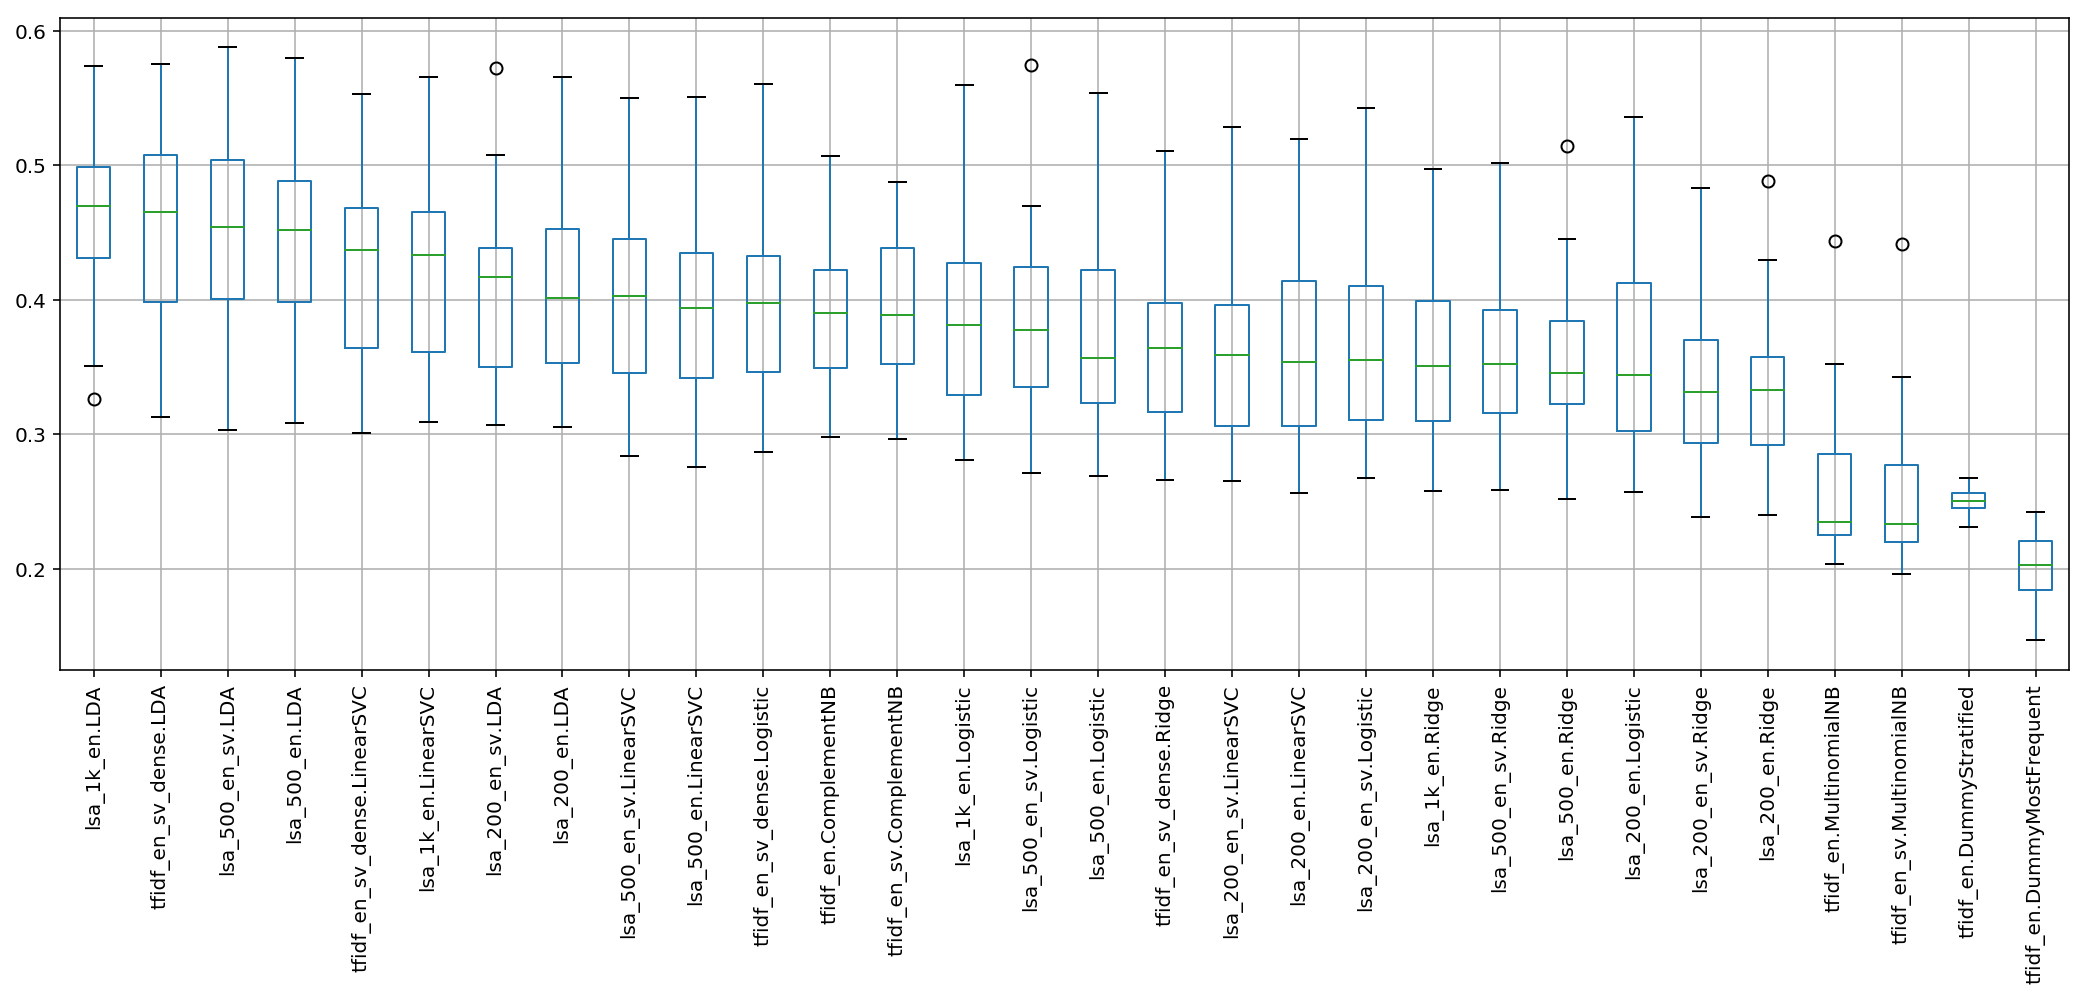

In [18]:
import matplotlib.pyplot as plt

df.T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [ ]:
from fgclassifier.utils import save_model

def clear_cache(model):
    if hasattr(model, 'steps'):
        for (name, step) in model.steps:
            clear_cache(step)
    if hasattr(model, 'cache'):
        model.cache = None
    return model

for name, model in results['models'].items():
    clear_cache(model)
    save_model(model)

2018-12-03 15:35:50,652 [INFO] Saving model to /opt/storage/models/dummy_transform_DummyStratified.pkl...
2018-12-03 15:35:50,665 [INFO] Saving model... Done.
2018-12-03 15:35:50,666 [INFO] Saving model to /opt/storage/models/dummy_transform_DummyMostFrequent.pkl...
2018-12-03 15:35:50,678 [INFO] Saving model... Done.
2018-12-03 15:35:50,679 [INFO] Saving model to /opt/storage/models/tfidf_en_MultinomialNB.pkl...
2018-12-03 15:36:09,843 [INFO] Saving model... Done.
2018-12-03 15:36:09,844 [INFO] Saving model to /opt/storage/models/tfidf_en_ComplementNB.pkl...
2018-12-03 15:36:28,356 [INFO] Saving model... Done.
2018-12-03 15:36:28,360 [INFO] Saving model to /opt/storage/models/tfidf_en_sv_MultinomialNB.pkl...
2018-12-03 15:36:49,704 [INFO] Saving model... Done.
2018-12-03 15:36:49,705 [INFO] Saving model to /opt/storage/models/tfidf_en_sv_ComplementNB.pkl...
2018-12-03 15:37:09,829 [INFO] Saving model... Done.
2018-12-03 15:37:09,830 [INFO] Saving model to /opt/storage/models/lsa_200_e

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [25]:
model = results['models']['lsa_500_en_LDA']
print(X_test[0:1].shape)
probas = model.predict_proba(X_test[0:1])
probas[0].shape

2018-12-03 11:52:24,510 [INFO]   lsa_500_en: transform use cache.


(1,)


(2000, 4)

In [20]:
model.predict(X_test[0:1])

2018-12-03 11:28:47,421 [INFO]   lsa_500_en: transform use cache.


array([[-2, -2, -2, ..., -2,  1, -2],
       [-2, -2, -2, ..., -2,  1, -2],
       [-2, -2, -2, ..., -2,  1,  1],
       ...,
       [-2, -2, -1, ...,  1, -1, -1],
       [-2, -2, -2, ..., -2,  0, -2],
       [-2, -2, -2, ..., -2,  1, -2]])